In [1]:
import os
IS_COLAB = not os.path.exists('/kaggle/input')
print(IS_COLAB) 

True


In [2]:
import tensorflow as tf
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.36.158.58:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.36.158.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.158.58:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [3]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
else:
  from kaggle_datasets import KaggleDatasets

Mounted at /content/drive


In [4]:
!pip install -q efficientnet
!pip install tensorflow_addons
import re
import os
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime

     |████████████████████████████████| 50 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [5]:
!pip uninstall -y kaggle
!pip install kaggle
!mkdir /root/.kaggle
!cp /content/drive/MyDrive/Kaggle/kaggle.json /root/.kaggle

!kaggle datasets download -d ks2019/happywhale-splits
!mkdir -p ../input/happywhale-splits
!unzip -n -qq happywhale-splits.zip -d ../input/happywhale-splits

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 2.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=448ccb3606f05cec47b49b794e0ddce5cc6796aa7bbd7d387912e11b1b4110e3
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  0% 0.00/3.11M [00:00<?, ?B/s]
100% 3.11M/3.11M [00:00<00:00, 135MB/s]


## Config

In [6]:
save_dir = '.'
EXPERIMENT = 23_1
run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')
print(run_ts)
if IS_COLAB:
    save_dir = f'/content/drive/MyDrive/Kaggle/HappyWhale-2022/experiments-{EXPERIMENT}/{run_ts}'
    !mkdir -p {save_dir}

20220402-160149


In [7]:
class config:
    
    
    SEED = 42
    FOLD_TO_RUN = 1 ## change this to train different fold
    FOLDS = 5 #was 5
    DEBUG = False
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = None
    
    
    ### Dataset
    BATCH_SIZE = 64 #* strategy.num_replicas_in_sync
    IMAGE_SIZE = 600 ## bigger image size for training
    N_CLASSES = 15587
    
    ### Model
    model_type = 'effnetv1' # 'effnetv2' #'effnetv1' or  efficientnetV2を使う場合は 'effnetv2s' or 'effnetv2m' or 'effnetv2l'
    EFF_NET = 7
    EFF_NETV2 = 's-21k-ft1k' #efficientnetv2-l-21k-ft1k / efficientnetv2-m-21k-ft1k
    FREEZE_BATCH_NORM = True 
    head = 'arcface' 
    EPOCHS = 30  ## was25 change this to 30 also can improve the score
    LR = 1e-5
    weight_decay = 1e-6
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Save-Directory
    save_dir = save_dir
    
    ### Inference
    KNN = 100
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

True


In [8]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv1_b7


In [9]:
with open(config.save_dir+'/config.json', 'w') as fp:
    json.dump({x:dict(config.__dict__)[x] for x in dict(config.__dict__) if not x.startswith('_')}, fp)

In [10]:
#GCS_PATH = 'gs://kds-d916c3252bf3bc5b3500b904f05f51ce57c8df85221d11b7711bcda9'  # Get GCS Path from kaggle notebook if GCS Path is expired
#GCS_PATH = 'gs://kds-4ea2689b5b32d7c3c5b9ad7af8d88ad2c2e56c079272a66a4326af55' #2022/3/20 background-removed-happywhale-dataset-tfrecords
GCS_PATH = 'gs://kds-810bb636871b8c74113aa8839f9084672024747bfb14317814309e6c' #2022/4/1 backfintfrecords

if not IS_COLAB:
    GCS_PATH = KaggleDatasets().get_gcs_path('backfintfrecords')
    
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')))
print(GCS_PATH)
print(len(train_files),len(test_files),count_data_items(train_files),count_data_items(test_files))

gs://kds-810bb636871b8c74113aa8839f9084672024747bfb14317814309e6c
10 10 41574 27943


## Data

In [11]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
#         "matches": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    image = decode_image(example['image'])
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [12]:
row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TRAIN = count_data_items(train_files)
print(N_TRAIN)
ds = get_training_dataset(train_files)

for (sample,label) in ds:
    img = sample['inp1']
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break
print(img.shape)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TEST = count_data_items(test_files)
print(N_TEST)
ds = get_test_dataset(test_files)

for (img,label) in ds:
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break
print(img.shape)

Output hidden; open in https://colab.research.google.com to view.

## Model

In [14]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [15]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2s':
    MODEL_NAME = enf2.EfficientNetV2S
elif config.model_type == 'effnetv2m':
    MODEL_NAME = enf2.EfficientNetV2M
elif config.model_type == 'effnetv2l':
    MODEL_NAME = enf2.EfficientNetV2L
elif config.model_type == 'effnetv2xl':
    MODEL_NAME = enf2.EfficientNetV2XL
else:
    MODEL_NAME = config.model_type
config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv1_b7


In [16]:
!pip install tensorflow-addons

In [17]:
import tensorflow_addons as tfa

In [18]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]
#from classification_models.keras import Classifiers
#model, preprocess_input = Classifiers.get('resnet34')
def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

# Function to create our EfficientNetB3 model
def get_model():

    if config.head=='arcface':
        head = ArcMarginProduct
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():
        
        margin = head(
            n_classes = config.N_CLASSES, 
            s = 30, 
            m = 0.3, 
            name=f'head/{config.head}', 
            dtype='float32'
            )

        inp = tf.keras.layers.Input(shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')

        if config.model_type == 'effnetv1':
            inp = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False,input_shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3])
            inp.layers[0]._name = 'inp1'
            #inp.summary()
            x1=tf.keras.layers.GlobalAveragePooling2D()(inp.layers[-1].output)
            x2=tf.keras.layers.GlobalAveragePooling2D()(inp.layers[-5].output)
            x3=tf.keras.layers.GlobalAveragePooling2D()(inp.layers[-7].output)
            x4=tf.keras.layers.GlobalAveragePooling2D()(inp.layers[-13].output)
            embed =  tf.concat([x1,x2,x3,x4],axis = 1) #どの層をconcutするかは調整してもいいかも。今回は[-1][-5][-7][-13]を抽出してconcut

            #embed = tf.keras.layers.GlobalAveragePooling2D()(x)

        elif 'effnetv2' in config.model_type:
            inp = MODEL_NAME(input_shape=(config.IMAGE_SIZE,config.IMAGE_SIZE, 3),num_classes = 0, pretrained='imagenet21k-ft1k')
            inp.layers[0]._name = 'inp1'
          
            x1=tf.keras.layers.GlobalAveragePooling2D()(inp.layers[-1].output)
            x2=tf.keras.layers.GlobalAveragePooling2D()(inp.layers[-5].output)
            x3=tf.keras.layers.GlobalAveragePooling2D()(inp.layers[-7].output)
            x4=tf.keras.layers.GlobalAveragePooling2D()(inp.layers[-13].output)
            embed =  tf.concat([x1,x2,x3,x4],axis = 1) #どの層をconcutするかは調整してもいいかも。今回は[-1][-5][-7][-13]を抽出してconcut
        
        else:
            embed = tfimm.create_model(config.model_type, pretrained="timm")(inp)
            #embed = tf.keras.layers.GlobalAveragePooling2D()(x)

        embed = tf.keras.layers.Dropout(0.3)(embed)
        embed = tf.keras.layers.Dense(2048)(embed)
        embed = tf.keras.layers.Dropout(0.2)(embed)
        #embed = tf.keras.layers.Dense(512)(embed)
        x = margin([embed, label])
        
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        
        model = tf.keras.models.Model(inputs = [inp.input, label], outputs = [output])
        embed_model = tf.keras.models.Model(inputs = inp.input, outputs = embed)  
        
        opt = tfa.optimizers.RectifiedAdam(learning_rate = config.LR, weight_decay=config.weight_decay)
        
        if config.FREEZE_BATCH_NORM:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

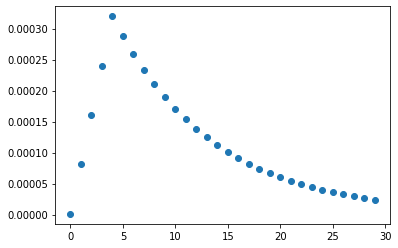

In [19]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * config.BATCH_SIZE  
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [20]:
class Snapshot(tf.keras.callbacks.Callback):
    
    def __init__(self,fold,snapshot_epochs=[]):
        super(Snapshot, self).__init__()
        self.snapshot_epochs = snapshot_epochs
        self.fold = fold
        
        
    def on_epoch_end(self, epoch, logs=None):
        # logs is a dictionary
#         print(f"epoch: {epoch}, train_acc: {logs['acc']}, valid_acc: {logs['val_acc']}")
        if epoch in self.snapshot_epochs: # your custom condition         
            self.model.save_weights(config.save_dir+f"/EF{config.MODEL_NAME}_epoch{epoch}.h5")
        self.model.save_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

## Train

In [21]:
TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS!=config.FOLD_TO_RUN]
VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS==config.FOLD_TO_RUN]
print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))

8 2 33258 8316


In [22]:
if config.DEBUG:
    TRAINING_FILENAMES = [TRAINING_FILENAMES[0]]
    VALIDATION_FILENAMES = [VALIDATION_FILENAMES[0]]
    print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))
    test_files = [test_files[0]]

In [23]:
seed_everything(config.SEED)
VERBOSE = 1
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
train_logger = tf.keras.callbacks.CSVLogger(config.save_dir+'/training-log-fold-%i.h5.csv'%config.FOLD_TO_RUN)
# SAVE BEST MODEL EACH FOLD        
sv_loss = tf.keras.callbacks.ModelCheckpoint(
    config.save_dir+f"/{config.MODEL_NAME}_loss_{config.FOLD_TO_RUN}.h5", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# BUILD MODEL
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
model.summary()

if config.RESUME:   
    model.load_weights(config.resume_model_wts)

258080768/258068648 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 600, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 300, 300, 64  1728        ['inp1[0][0]']                   
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 300, 300, 64  256         ['stem_conv[0][0]']              
                           

In [24]:
print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (config.IMAGE_SIZE,config.EFF_NET,config.BATCH_SIZE))
history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = config.EPOCHS,
                callbacks = [snap,get_lr_callback(),train_logger,sv_loss], 
                verbose = VERBOSE)
                

#### Image Size 600 with EfficientNet B7 and batch_size 64
Epoch 1/30
  6/519 [..............................] - ETA: 7:43 - loss: 18.7201 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 17.6852s). Check your callbacks.


519/519 [==============================] - 872s 1s/step - loss: 18.7043 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 18.6610 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-06
Epoch 2/30
519/519 [==============================] - 540s 1s/step - loss: 17.3818 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 17.9047 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0011 - lr: 8.0750e-05
Epoch 3/30
519/519 [==============================] - 543s 1s/step - loss: 15.9311 - sparse_categorical_accuracy: 0.0023 - sparse_top_k_categorical_accuracy: 0.0055 - val_loss: 15.6735 - val_sparse_categorical_accuracy: 0.0417 - val_sparse_top_k_categorical_accuracy: 0.0596 - lr: 1.6050e-04
Epoch 4/30
519/519 [==============================] - 540s 1s/step - loss: 13.7936 - sparse_categorical_acc

In [25]:
model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_loss_{config.FOLD_TO_RUN}.h5")

# Evaluation

In [26]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds,verbose=0)
    return embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0
    
f = open ("../input/happywhale-splits/individual_ids.json", "r") #この階層のフォルダにHappyWhale Splitsというファイルを保存しておく。kaggleからダウンロード
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [27]:
train_targets = []
train_embeddings = []
train_data_list=[] 

for filename in tqdm(TRAINING_FILENAMES):
    embeddings = get_embeddings(filename)
    with open(config.save_dir+f'train_{filename.split("/")[-1]}_{config.FOLD_TO_RUN}.npy', 'wb') as f:
      np.save(f, embeddings)    
    targets = get_targets(filename)
    train_embeddings.append(embeddings)
    train_targets.append(targets)
    train_data_list.append([filename,embeddings])
train_embeddings_df = pd.DataFrame(train_data_list, columns=['filename', 'embeddings'])
train_embeddings_df['FOLD_TO_RUN']=config.FOLD_TO_RUN
train_embeddings_df.to_csv(config.save_dir+f"/train_embeddings_{config.FOLD_TO_RUN}.csv",index=False)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)

  0%|          | 0/8 [00:00<?, ?it/s]

In [28]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [29]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
val_data_list=[] 
for filename in tqdm(VALIDATION_FILENAMES):
    embeddings = get_embeddings(filename)
    with open(config.save_dir+f'val_{filename.split("/")[-1]}_{config.FOLD_TO_RUN}.npy', 'wb') as f:
      np.save(f, embeddings) 
    val_data_list.append([filename,embeddings])
    targets = get_targets(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
val_embeddings_df = pd.DataFrame(val_data_list, columns=['filename', 'embeddings'])
val_embeddings_df['FOLD_TO_RUN']=config.FOLD_TO_RUN
val_embeddings_df.to_csv(config.save_dir+f"/val_embeddings_{config.FOLD_TO_RUN}.csv",index=False)

test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets)

  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

new_individual    1976
37c7aba965a5        77
a6e325d8e924        43
19fbb960f07d        38
f195c38bcf17        36
                  ... 
3fa60b63e160         1
65f887e8845c         1
2255bb64e41e         1
7e147a96ad00         1
af5b408252a5         1
Name: target, Length: 2594, dtype: int64

In [31]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv(config.save_dir+ '/val_neighbors.csv')
test_df.image.value_counts().value_counts()

test_df

  0%|          | 0/8316 [00:00<?, ?it/s]

,image,target,confidence
0,27eed76d08871e.jpg,62ec6fea7ad5,0.999662
1,a53da919f6ae12.jpg,ce6e37904aa4,0.999133
2,2dcfe01310f0cd.jpg,37c7aba965a5,0.998918
3,a390d57400dd56.jpg,ce6e37904aa4,0.998838
4,b17b804fd3c2bc.jpg,ce6e37904aa4,0.998715
...,...,...,...
306649,1a38ad219d13fb.jpg,609e11f16cc1,0.215020
306650,1a38ad219d13fb.jpg,6625310dd87d,0.214983
306651,1a38ad219d13fb.jpg,0cde8e4bf3fe,0.214911
306652,1a38ad219d13fb.jpg,104db7bf2203,0.213176


In [32]:
## Compute CV
best_th = 0
best_cv = 0
for th in [0.1*x for x in range(11)]:
    all_preds = get_predictions(test_df,threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target,preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv>best_cv:
        best_th = th
        best_cv = cv

0it [00:00, ?it/s]

  0%|          | 0/8316 [00:00<?, ?it/s]

CV at threshold 0.0: 0.7691197691197673


0it [00:00, ?it/s]

  0%|          | 0/8316 [00:00<?, ?it/s]

CV at threshold 0.1: 0.7691197691197673


0it [00:00, ?it/s]

  0%|          | 0/8316 [00:00<?, ?it/s]

CV at threshold 0.2: 0.7691197691197673


0it [00:00, ?it/s]

  0%|          | 0/8316 [00:00<?, ?it/s]

CV at threshold 0.30000000000000004: 0.7691197691197673


0it [00:00, ?it/s]

  0%|          | 0/8316 [00:00<?, ?it/s]

CV at threshold 0.4: 0.7720057720057699


0it [00:00, ?it/s]

  0%|          | 0/8316 [00:00<?, ?it/s]

CV at threshold 0.5: 0.8308080808080777


0it [00:00, ?it/s]

  0%|          | 0/8316 [00:00<?, ?it/s]

CV at threshold 0.6000000000000001: 0.857683982683979


0it [00:00, ?it/s]

  0%|          | 0/8316 [00:00<?, ?it/s]

CV at threshold 0.7000000000000001: 0.8345959595959563


0it [00:00, ?it/s]

  0%|          | 0/8316 [00:00<?, ?it/s]

CV at threshold 0.8: 0.7944324194324167


0it [00:00, ?it/s]

  0%|          | 0/8316 [00:00<?, ?it/s]

CV at threshold 0.9: 0.7316017316017303


0it [00:00, ?it/s]

  0%|          | 0/8316 [00:00<?, ?it/s]

CV at threshold 1.0: 0.5683621933621935


In [33]:
print("Best threshold",best_th)
print("Best cv",best_cv)
val_targets_df.describe()

Best threshold 0.6000000000000001
Best cv 0.857683982683979


,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0
count,8316.000000,8316.000000,8316.000000,8316.000000,8316.000000,8316.000000,8316.000000,8316.000000,8316.000000,8316.000000,8316.000000
mean,0.769120,0.769120,0.769120,0.769120,0.772006,0.830808,0.857684,0.834596,0.794432,0.731602,0.568362
std,0.332256,0.332256,0.332256,0.332256,0.332077,0.322845,0.314901,0.321873,0.329826,0.332297,0.278861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] = val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

{False: 6340, True: 1976}
best_threshold 0.5


is_new_individual,False,True,adjusted_cv
0.0,0.852997,0.500000,0.817697
0.1,0.852997,0.500000,0.817697
0.2,0.852997,0.500000,0.817697
0.30000000000000004,0.852997,0.500000,0.817697
0.4,0.852918,0.512399,0.818866
0.5,0.847003,0.778846,0.840187
0.6000000000000001,0.825946,0.959514,0.839303
0.7000000000000001,0.785726,0.991397,0.806293
0.8,0.731073,0.997723,0.757738
0.9,0.647950,1.000000,0.683155


# Inference

In [35]:
train_embeddings = np.concatenate([train_embeddings,val_embeddings])
train_targets = np.concatenate([train_targets,val_targets])
print(train_embeddings.shape,train_targets.shape)

(41574, 2048) (41574,)


In [36]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [37]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
test_data_list=[] 
for filename in tqdm(test_files):
    embeddings = get_embeddings(filename)
    with open(config.save_dir+f'test_{filename.split("/")[-1]}_{config.FOLD_TO_RUN}.npy', 'wb') as f:
      np.save(f, embeddings) 
    test_data_list.append([filename,embeddings])
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)

test_embeddings_df = pd.DataFrame(test_data_list, columns=['filename', 'embeddings'])
test_embeddings_df['FOLD_TO_RUN']=config.FOLD_TO_RUN
test_embeddings_df.to_csv(config.save_dir+f"/test_embeddings_{config.FOLD_TO_RUN}.csv",index=False)



test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

  0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
sample_submission = pd.read_csv("/content/drive/MyDrive/Kaggle/sample_submission.csv",index_col='image')
print(len(test_ids),len(sample_submission))
test_df = []
test_conf_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]

    temp = list(zip(targets,distances))
    temp_df = pd.DataFrame(temp,columns = ["predictions","conf"])
    temp_df = temp_df.sort_values("conf", ascending=False) #confで降順にソート
    temp_df.drop_duplicates(keep = "first",subset = ["predictions"], inplace = True) #重複削除
    
    # predictions = temp_df["predictions"][:5].values.tolist()
    # confs = temp_df["conf"][:5].values.tolist()

    # test_conf_subset = pd.DataFrame({'id' : id_,
    #                                 'predictions' : predictions[0],
    #                                 'predictions1' : targets[1],
    #                                 'predictions2' : targets[2],
    #                                 'conf1' : 1 - confs[0],
    #                                 'conf2' : 1 - confs[1],
    #                                 'conf3' : 1 - confs[2],
    #                                 'conf4' : 1 - confs[3],
    #                                 'conf5' : 1 - confs[4]},
    #                                 index=[i])
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    # test_conf_df.append(test_conf_subset)
    test_df.append(subset_preds)

# test_confidence_df = pd.concat(test_conf_df).reset_index(drop=True)
# test_confidence_df = test_confidence_df.sort_values('conf1',ascending=False).reset_index(drop=True)
# test_confidence_df['predictions'] = test_confidence_df['predictions'].map(target_encodings)
# test_confidence_df.to_csv('/content/drive/MyDrive/Happy-Whoel/tf_model/test_confidence.csv')

test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv(config.save_dir+ '/test_neighbors.csv')
test_df.image.value_counts().value_counts()

# test_confidence_df.head()

27942 27956


  0%|          | 0/27942 [00:00<?, ?it/s]

1      596
38     504
35     494
42     489
34     478
      ... 
97       7
98       6
96       6
99       1
100      1
Name: image, Length: 100, dtype: int64

In [39]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']
conf_tmp_list = [0.001,0.001,0.001,0.001,0.001]
test_df

,image,target,confidence
0,7a785b700b0339.jpg,c93996835aa8,0.998976
1,dd19360cf04d76.jpg,be3543fc7c74,0.998096
2,5fb61ff7e07076.jpg,2e0b381d3467,0.997922
3,cf48c5e9be0763.jpg,600ab1de92d9,0.997684
4,90582a6214b899.jpg,2e0b381d3467,0.997058
...,...,...,...
1107206,35fddc4b58b627.jpg,f406ff1c015b,0.200820
1107207,35fddc4b58b627.jpg,74a05c50e78b,0.200729
1107208,35fddc4b58b627.jpg,c3287e843265,0.200253
1107209,35fddc4b58b627.jpg,d5550b312158,0.199551


In [40]:
predictions = {}
confs = {}
for i,row in tqdm(test_df.iterrows()):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
        confs[row.image].append(row.confidence)
    elif row.confidence>best_threshold_adjusted:
        predictions[row.image] = [row.target,'new_individual']
        confs[row.image] = [row.confidence,best_threshold_adjusted]
    else:
        predictions[row.image] = ['new_individual',row.target]
        confs[row.image] = [best_threshold_adjusted,row.confidence]
        
for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        confs[x] = confs[x] + conf_tmp_list
        predictions[x] = predictions[x][:5]
        confs[x] = confs[x][:5]
    predictions[x] = ' '.join(predictions[x])
    confs[x] = ' '.join(map(str,confs[x]))
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv(config.save_dir+ "/submission.csv" ,index=False)

# ensemble
confidences = pd.Series(confs).reset_index()
confidences.columns = ['image','confs']
ensemble_df = pd.merge(predictions,confidences)
ensemble_df.to_csv(config.save_dir+f"/ensemble_{config.MODEL_NAME}_fold{config.FOLD_TO_RUN}.csv",index=False)

predictions.head()

0it [00:00, ?it/s]

  0%|          | 0/27942 [00:00<?, ?it/s]

,image,predictions
0,7a785b700b0339.jpg,c93996835aa8 new_individual d36d5a07500f ffa4b...
1,dd19360cf04d76.jpg,be3543fc7c74 new_individual cca34a927503 5354a...
2,5fb61ff7e07076.jpg,2e0b381d3467 new_individual 780fefdb6198 3edde...
3,cf48c5e9be0763.jpg,600ab1de92d9 new_individual 938b7e931166 5bf17...
4,90582a6214b899.jpg,2e0b381d3467 new_individual 780fefdb6198 3edde...


In [41]:
df2 = pd.read_csv("/content/drive/MyDrive/Kaggle/HappyWhale-2022/5folds_backfin_fullbody.csv")
ids = np.load("/content/drive/MyDrive/Kaggle/HappyWhale-2022/ids_without_backfin.npy", allow_pickle = True) #whales without backfins determined with a simple classifier

In [42]:
ids2 = df2["image"][~df2["image"].isin(predictions["image"])] #images without a bounding box

In [43]:
submission = pd.concat([
    predictions[~(predictions["image"].isin(ids))],
    df2[df2["image"].isin(ids)],
    df2[df2["image"].isin(ids2)]
])

In [44]:
submission = submission.drop_duplicates()

In [45]:
submission.to_csv(config.save_dir+ "/submission_comp.csv",index=False)
submission.head()


,image,predictions
0,7a785b700b0339.jpg,c93996835aa8 new_individual d36d5a07500f ffa4b...
1,dd19360cf04d76.jpg,be3543fc7c74 new_individual cca34a927503 5354a...
2,5fb61ff7e07076.jpg,2e0b381d3467 new_individual 780fefdb6198 3edde...
3,cf48c5e9be0763.jpg,600ab1de92d9 new_individual 938b7e931166 5bf17...
4,90582a6214b899.jpg,2e0b381d3467 new_individual 780fefdb6198 3edde...


In [46]:
#submission.head(100)